## Code Imports and Setup

In [5]:
import os
import pathlib
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import PIL.Image as Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)

## Import Model

In [7]:
!pip install -q pyyaml h5py

In [51]:
model = tf.keras.models.load_model('data/saved_model/final_model.h5')

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [53]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [54]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(224, 224, 3)

## Predict on new Data (Labelled)

In [55]:
filenamesJPEG = glob.glob('Data/Test/*.jpeg')
filenamesJPG = glob.glob('Data/Test/*.jpg')

In [56]:
len(filenamesJPG)

28

In [57]:
len(filenamesJPEG)

24

In [58]:
filenamesJPEG.extend(filenamesJPG)
filenames = filenamesJPEG
len(filenames)

52

In [59]:
test_df = pd.DataFrame(filenames)

In [60]:
test_df.rename(columns = {0: 'Filename'}, inplace = True)
test_df.head()

Filename
0  Data/Test/01-Yaseen.jpeg
1    Data/Test/18-Wina.jpeg
2  Data/Test/01-Hannah.jpeg
3   Data/Test/27-Zaini.jpeg
4  Data/Test/01-Danish.jpeg

In [61]:
test_df['Split'] = test_df['Filename'].str.split('/')
test_df.head()

Filename                         Split
0  Data/Test/01-Yaseen.jpeg  [Data, Test, 01-Yaseen.jpeg]
1    Data/Test/18-Wina.jpeg    [Data, Test, 18-Wina.jpeg]
2  Data/Test/01-Hannah.jpeg  [Data, Test, 01-Hannah.jpeg]
3   Data/Test/27-Zaini.jpeg   [Data, Test, 27-Zaini.jpeg]
4  Data/Test/01-Danish.jpeg  [Data, Test, 01-Danish.jpeg]

In [62]:
def retrieve_age(filename_list):
    
    img_name = filename_list[2]
    
    age = img_name[:2]
    
    return age

In [63]:
test_df['age'] = test_df['Split'].apply(retrieve_age)
test_df['age'] = test_df['age'].apply(int)
test_df.head()

Filename                         Split  age
0  Data/Test/01-Yaseen.jpeg  [Data, Test, 01-Yaseen.jpeg]    1
1    Data/Test/18-Wina.jpeg    [Data, Test, 18-Wina.jpeg]   18
2  Data/Test/01-Hannah.jpeg  [Data, Test, 01-Hannah.jpeg]    1
3   Data/Test/27-Zaini.jpeg   [Data, Test, 27-Zaini.jpeg]   27
4  Data/Test/01-Danish.jpeg  [Data, Test, 01-Danish.jpeg]    1

In [64]:
def age_classifier(age):
    
    if age == 1:
        
        age_group = 'Baby'
        
    elif age in range(2, 4):
        
        age_group = 'Toddler'
        
    elif age in range(4, 9):
        
        age_group = 'Child'
        
    elif age in range(9, 14):
        
        age_group = 'Adolescent'
        
    elif age in range(14, 19):
        
        age_group = 'Teenager'
        
    elif age in range(19, 25):
        
        age_group = 'Young Adult'
        
    elif age in range(25, 35):
        
        age_group = 'Adult'
        
    elif age in range(35, 45):
        
        age_group = 'Mature Adult'
        
    elif age in range(45, 59):
        
        age_group = 'Middle Age'
        
    else:
        
        age_group = 'Senior'
               
    return age_group

In [65]:
test_df['age group'] = test_df['age'].apply(age_classifier)
test_df.head()

Filename                         Split  age age group
0  Data/Test/01-Yaseen.jpeg  [Data, Test, 01-Yaseen.jpeg]    1      Baby
1    Data/Test/18-Wina.jpeg    [Data, Test, 18-Wina.jpeg]   18  Teenager
2  Data/Test/01-Hannah.jpeg  [Data, Test, 01-Hannah.jpeg]    1      Baby
3   Data/Test/27-Zaini.jpeg   [Data, Test, 27-Zaini.jpeg]   27     Adult
4  Data/Test/01-Danish.jpeg  [Data, Test, 01-Danish.jpeg]    1      Baby

In [66]:
test_df.drop(columns = ['Split'], inplace = True)

In [67]:
age_groups = ['Baby', 'Toddler', 'Child', 'Adolescent', 'Teenager',
              'Young Adult', 'Adult', 'Mature Adult', 'Middle Age', 'Senior']

len(age_groups)

10

In [68]:
def age_labeler(age_group):
    
    label = age_groups.index(age_group)
    
    return label

In [69]:
test_df['age label'] = test_df['age group'].apply(age_labeler)
test_df.head(2)

Filename  age age group  age label
0  Data/Test/01-Yaseen.jpeg    1      Baby          0
1    Data/Test/18-Wina.jpeg   18  Teenager          4

In [70]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string,channels=3)
    image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, 10)
    return image_resized, label

In [71]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['Filename'], test_df['age label']))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(32)

In [72]:
preds = model.predict(test_dataset)
preds[:3]

array([[5.5057347e-01, 4.4094568e-01, 7.4456711e-03, 8.5510888e-05,
        2.8919643e-05, 4.6593600e-04, 1.9704197e-04, 5.8112222e-05,
        6.7760833e-05, 1.3191292e-04],
       [2.5057148e-02, 9.7466055e-03, 1.1908901e-02, 7.5033970e-02,
        2.2747630e-01, 2.8055760e-01, 2.2179191e-01, 1.2063686e-01,
        9.2397779e-03, 1.8550916e-02],
       [3.9031416e-01, 5.5943310e-01, 4.7121245e-02, 9.8005997e-04,
        4.2423831e-05, 1.5628929e-03, 2.1142753e-04, 1.0083095e-04,
        1.0443813e-04, 1.2941184e-04]], dtype=float32)

In [73]:
predictions = [np.argmax(p) for p in preds]
predictions[:3]

[0, 5, 1]

In [74]:
len(predictions)

52

In [75]:
test_df['Predicted Label'] = predictions
test_df.head()

Filename  age age group  age label  Predicted Label
0  Data/Test/01-Yaseen.jpeg    1      Baby          0                0
1    Data/Test/18-Wina.jpeg   18  Teenager          4                5
2  Data/Test/01-Hannah.jpeg    1      Baby          0                1
3   Data/Test/27-Zaini.jpeg   27     Adult          6                6
4  Data/Test/01-Danish.jpeg    1      Baby          0                1

In [76]:
accuracy_score(test_df['age label'], test_df['Predicted Label'])

0.3076923076923077

In [77]:
mean_absolute_error(test_df['age label'], test_df['Predicted Label'])

0.8846153846153846

In [78]:
test_df['Difference'] = test_df['Predicted Label'] - test_df['age label']
test_df['Difference'] = test_df['Difference'].apply(abs)
test_df.head()

Filename  age age group  age label  Predicted Label  \
0  Data/Test/01-Yaseen.jpeg    1      Baby          0                0   
1    Data/Test/18-Wina.jpeg   18  Teenager          4                5   
2  Data/Test/01-Hannah.jpeg    1      Baby          0                1   
3   Data/Test/27-Zaini.jpeg   27     Adult          6                6   
4  Data/Test/01-Danish.jpeg    1      Baby          0                1   

   Difference  
0           0  
1           1  
2           1  
3           0  
4           1

In [79]:
test_df.sort_values(by = 'age', inplace = True)
test_df.reset_index(drop = True, inplace = True)
test_df.head()

Filename  age age group  age label  Predicted Label  \
0  Data/Test/01-Yaseen.jpeg    1      Baby          0                0   
1  Data/Test/01-Ismail.jpeg    1      Baby          0                1   
2  Data/Test/01-Hannah.jpeg    1      Baby          0                1   
3  Data/Test/01-Danish.jpeg    1      Baby          0                1   
4  Data/Test/01-Danial.jpeg    1      Baby          0                1   

   Difference  
0           0  
1           1  
2           1  
3           1  
4           1

In [80]:
misclass_count = test_df['Difference'].value_counts().to_frame(name = 'Count').sort_index()
misclass_count

Count
0     16
1     29
2      5
3      1
4      1

In [81]:
print("The exact accuracy for the model is " + str(round(misclass_count.iloc[0, 0] / test_df.shape[0] * 100)) + "%")

The exact accuracy for the model is 31%


In [82]:
print("The accuracy for the model up to 1-class difference is " + 
      str(round((misclass_count.iloc[0, 0] + misclass_count.iloc[1, 0]) / test_df.shape[0] * 100)) + "%")

The accuracy for the model up to 1-class difference is 87%


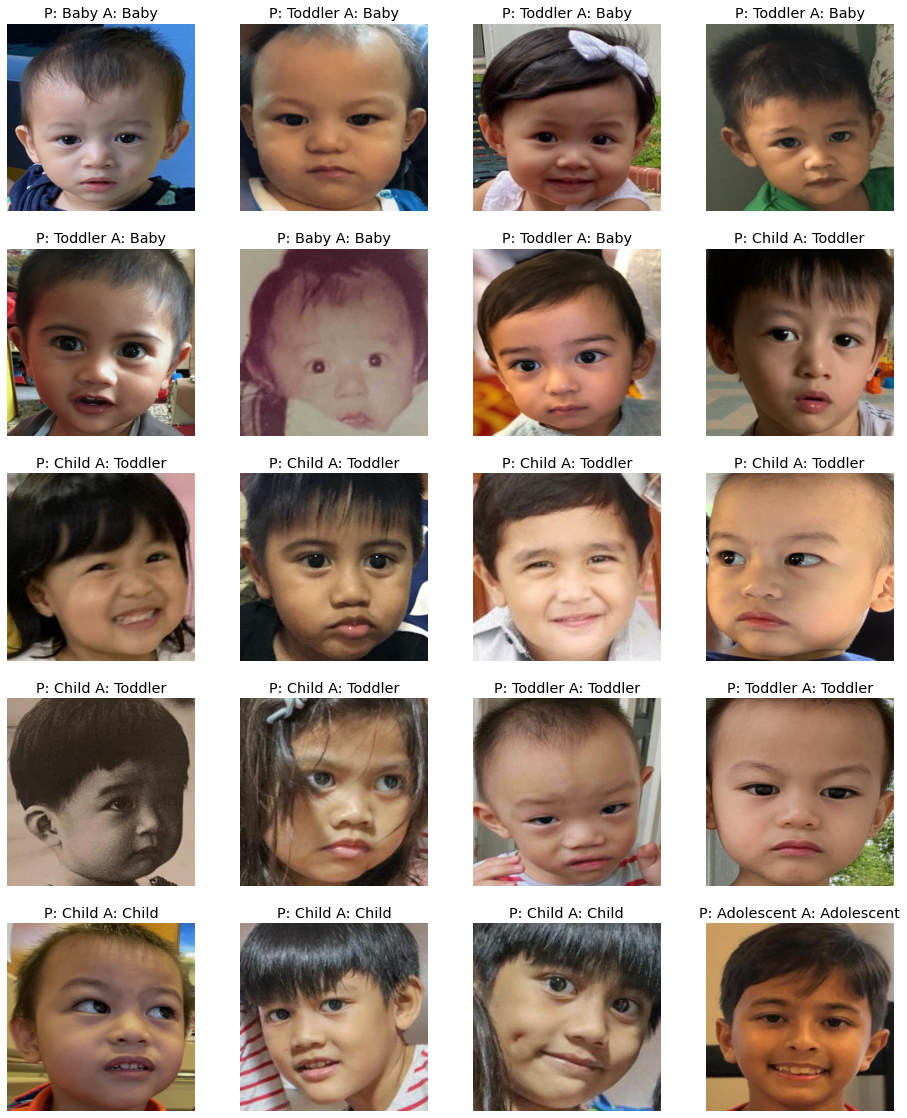

In [86]:
plt.figure(figsize=(16, 20))

for i in range(20):
    
    ax = plt.subplot(5, 4, i + 1)
    
    image = Image.open(test_df['Filename'][i]).resize((224, 224))
    prediction = test_df['Predicted Label'][i]
    age_label = test_df['age group'][i]
    
    plt.imshow(image)
    plt.title("P: " + age_groups[prediction] + " A: " + age_label)
    plt.axis("off")

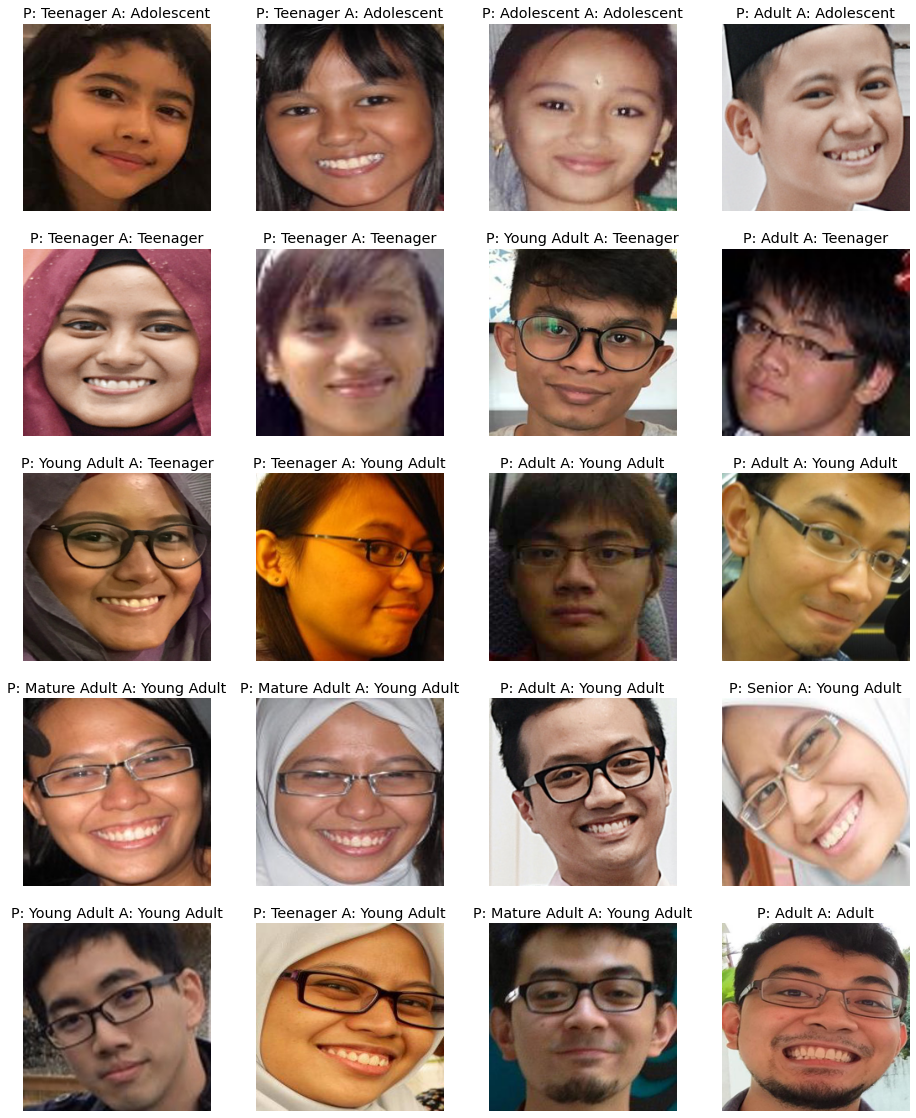

In [87]:
plt.figure(figsize=(16, 20))

for i,j in zip(range(20), range(20, 40)):
    
    ax = plt.subplot(5, 4, i + 1)
    
    image = Image.open(test_df['Filename'][j]).resize((224, 224))
    prediction = test_df['Predicted Label'][j]
    age_label = test_df['age group'][j]
    
    plt.imshow(image)
    plt.title("P: " + age_groups[prediction] + " A: " + age_label)
    plt.axis("off")

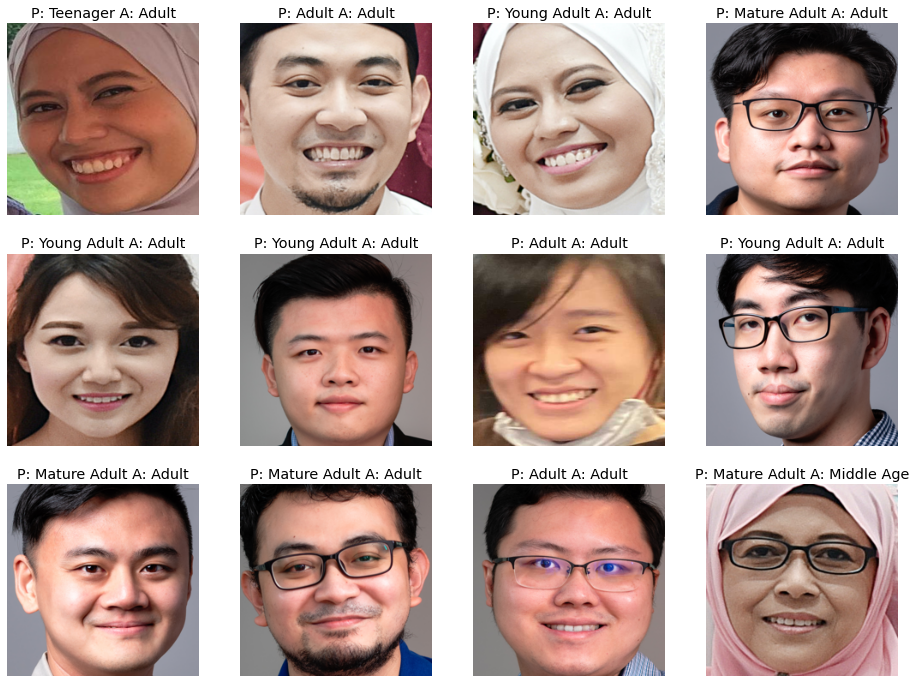

In [88]:
plt.figure(figsize=(16, 12))

for i,j in zip(range(20), range(40, 52)):
    
    ax = plt.subplot(3, 4, i + 1)
    
    image = Image.open(test_df['Filename'][j]).resize((224, 224))
    prediction = test_df['Predicted Label'][j]
    age_label = test_df['age group'][j]
    
    plt.imshow(image)
    plt.title("P: " + age_groups[prediction] + " A: " + age_label)
    plt.axis("off")

## Predict on New Data (unlabelled)

In [105]:
PredFilenamesJPEG = glob.glob('Data/Predict/*.jpeg')
PredFilenamesJPG = glob.glob('Data/Predict/*.jpg')

In [106]:
PredFilenamesJPEG.extend(PredFilenamesJPG)
PredFilenames = PredFilenamesJPEG
len(PredFilenames)

21

In [107]:
PredFilenames[:2]

['Data/Predict/darion1.jpeg', 'Data/Predict/Alicia-GA.jpg']

In [108]:
def predict_image(filename):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string,channels=3)
    image_resized = tf.image.resize(image_decoded, [224, 224])
    
    img_array = tf.expand_dims(image_resized, 0) # Create a batch
    prediction = model.predict(img_array)
    prediction = np.argmax(prediction)
    
    return prediction

In [111]:
predict_image('Data/Predict/darion1.jpeg')

4

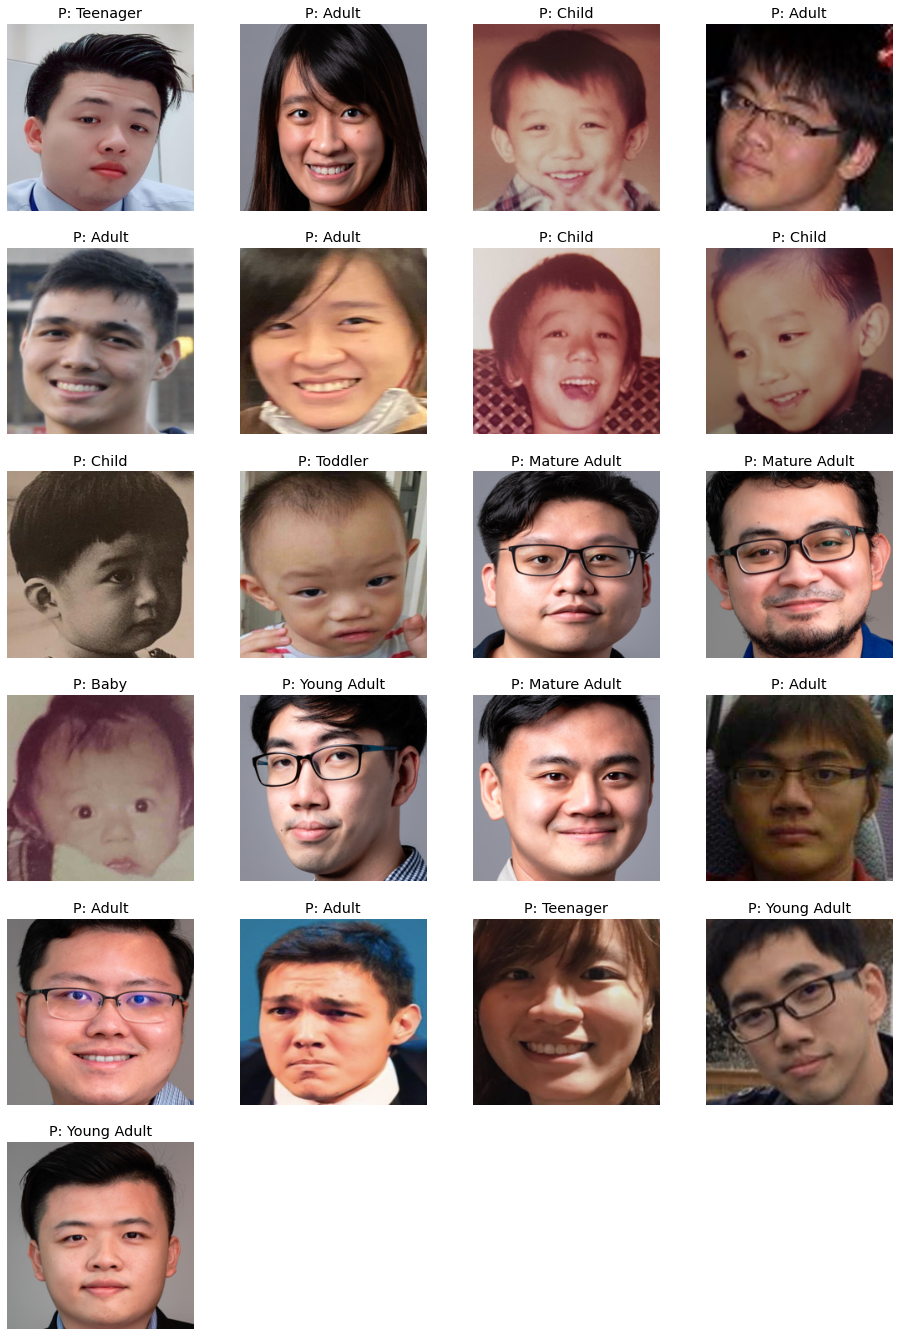

In [110]:
plt.figure(figsize=(16, 24))

for i in range(21):
    
    ax = plt.subplot(6, 4, i + 1)
    
    image = Image.open(PredFilenames[i]).resize((224, 224))
    prediction = predict_image(PredFilenames[i])
    
    plt.imshow(image)
    plt.title("P: " + age_groups[prediction])
    plt.axis("off")